In [32]:
# Imports 
import os
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import collections
from itertools import combinations
from collections import defaultdict
import itertools
import matplotlib.cm as cm
import networkx as nx

## Scraping naively page by page the models names and versions in huggingface 

In [99]:
models = set()

for i in range(1,15015) :
  print("Iteration: ", i)

  url = f"hhttps://huggingface.co/models?p={i}&sort=trending"

  response = requests.get(url)

  soup = BeautifulSoup(response.content.decode('utf8'))

  for model in soup.find_all('article'): 

    model_name = model.find('a').attrs['href'][1:]

    models.add(model_name)
  
  with open("./data/__bulk__.txt", "w") as file:
    for element in models:
      file.write(element + "\n")


Iteration:  1


NameError: name 'feature_tag' is not defined

## Global ratio of adoption of semantic versionning in the bulk scrape of huggingface

In [ ]:

models = []

# Open the file in read mode
with open('./data/__bulk__.txt', 'r') as file:
    # Read all lines and store them in the 'modules' variable
    # Use strip() to remove any leading/trailing whitespace (including newlines)
    models = [line.strip() for line in file.readlines()]

# # Regular expression pattern to match various version formats (vX, vX.X, vX-X, vX.X.X, etc.)
pattern = r'[vV]\d'

# Define the regular expression pattern
# pattern = r'\b(small|tiny|large|base)\b'

# Counter for models with versions
models_with_versions = 0

# Iterate over the models and count those with versions
for model in models:
    if re.search(pattern, model):
        models_with_versions += 1


print(f"Total models: {len(models)}")
print(f"Total models with versions: {models_with_versions}")

# Calculate the ratio of models with versions to total models

ratio = models_with_versions / len(models)

labels = ['Models with versions', 'Models without versions']
values = [models_with_versions, len(models) - models_with_versions]

# Plot the pie chart
plt.pie(values, labels=labels, autopct='%.2f%%')
plt.title('Ratio of models with versions to total models')
plt.show()

# Plot the bar chart
plt.bar(labels, values)
plt.title('Ratio of models with versions to total models')
plt.show()


Total models: 200506
Total models with versions: 34420


## Scraping models names and version per model category (tag type) in huggingface

In [ ]:

print("Scrapping model tags...");

pipeline_tags = [];
url = f"https://huggingface.co/models"
response = requests.get(url)
soup = BeautifulSoup(response.content.decode('utf8'))

for model in soup.find_all('a', class_='tag tag-white'):
  tag = model.attrs['href'][1:].split('=')[1]
  pipeline_tags.append(tag)

print("Model tags scrapped successfully, Total tags: ", len(pipeline_tags))

for model_tag in pipeline_tags:
  print("Scrapping models for tag: ", model_tag)

  url = f"https://huggingface.co/models?pipeline_tag={model_tag}&sort=trending"
  response = requests.get(url)
  soup = BeautifulSoup(response.content.decode('utf8'))
  models_count = soup.find('div', class_='ml-3 w-16 font-normal text-gray-400').text
  models_counted = 0;

  with open(model_tag+".txt", "w") as file:
    for model in soup.find_all('article'): 
      model_name = model.find('a').attrs['href'][1:]
      file.write(model_name + "\n")
      models_counted += 1

  index = 1

  while models_counted < int(models_count.replace(',', '').replace(' ', '').replace('.', ' ')):
    url = f"https://huggingface.co/models?pipeline_tag={model_tag}&p={index}&sort=trending"
    response = requests.get(url)
    soup = BeautifulSoup(response.content.decode('utf8'))

    with open(model_tag+".txt", "a") as file:
      for model in soup.find_all('article'): 
        model_name = model.find('a').attrs['href'][1:]
        file.write(model_name + "\n")
        models_counted += 1

    index += 1

## Counting the number of models 

In [ ]:
def count_lines_in_directory(directory):
    total_lines = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == '__bulk__.txt':
                continue
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                total_lines += len(lines)
    return total_lines

directory = './data'
total_lines = count_lines_in_directory(directory)
print(f'Total lines: {total_lines}')


Total lines: 239091


## Making sure no duplicate entry exists in the sample under study

In [ ]:
directory = 'data'
exclude_file = '__bulk__.txt'
modules_names_entries = set()
files_count = 0

for filename in os.listdir(directory):
    if filename != exclude_file:
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            files_count += 1
            print(f'Checking {filename}...')
            for line in file:
                if line in modules_names_entries:
                    # Do something with the repeated line
                    # For example, you can add it to a list or print it
                    print(f'Repeated line in {filename}: {line}')
                else:
                    modules_names_entries.add(line)

print(f'Number of files checked: {files_count}')
print(f'Number of lines checked: {len(modules_names_entries)}')

## Extracting adoption ratios : Globally (again) and per Category too

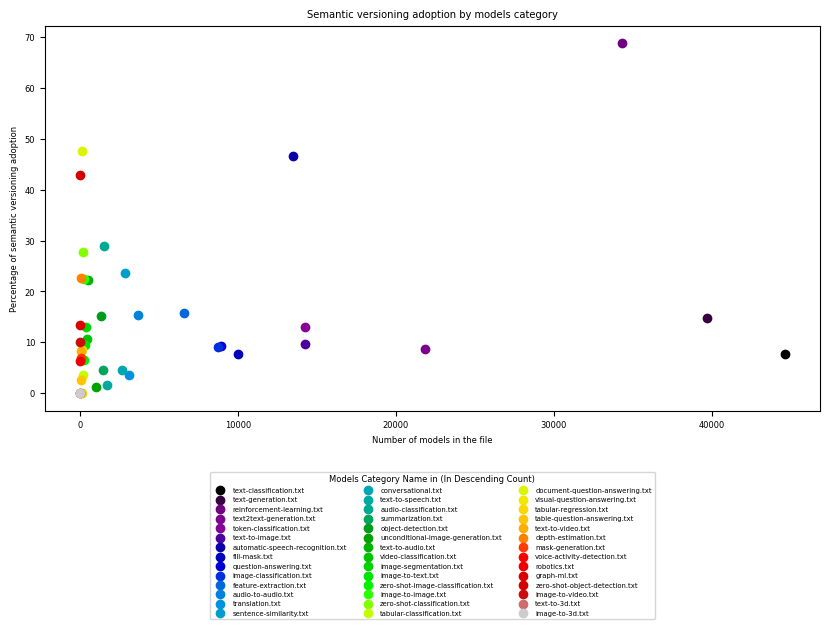

In [ ]:
# Define the semantic versioning regex pattern
version_regex = r"[vV]\d[.-]?\d?[.-]?\d?"

# Initialize counters
file_count = 0
version_count = 0

# Initialize a dictionary to store the version counts by file name
version_counts_by_file = {}
models_countn_by_file = {}

# Iterate through the files in the directory
for filename in os.listdir('./data'):
    if filename != "__bulk__.txt" and filename.endswith(".txt"):
        file_count += 1
        version_counts_by_file[filename] = 0
        models_countn_by_file[filename] = 0

        # Open the file and iterate through each line
        with open(os.path.join('./data', filename), 'r') as file:
            for line in file:
                # Check if the line contains a semantic versioning string
                models_countn_by_file[filename] += 1
                if re.search(version_regex, line):
                    version_count += 1
                    version_counts_by_file[filename] += 1

# Global version adoption ratio
number_of_models = sum([models_countn_by_file[key] for key in models_countn_by_file.keys()])
number_of_models_with_versions = sum([version_counts_by_file[key] for key in version_counts_by_file.keys()])

plt.pie([number_of_models_with_versions, number_of_models - number_of_models_with_versions], labels=['Models with versions', 'Models without versions'], autopct='%.2f%%')
plt.title('Ratio of models with versions to total models')
plt.show()

# Reorder the dictionary by value count (descending)
models_countn_by_file = dict(sorted(models_countn_by_file.items(), key=lambda item: item[1], reverse=True))
# Reorder by order of keys in the models_countn_by_file dictionary
version_counts_by_file = {key: version_counts_by_file[key] for key in models_countn_by_file.keys()}

# Calculate the number of subplots needed (one for each file)
num_files = len(version_counts_by_file)

# Calculate the number of rows needed
num_rows = num_files // 6
if num_files % 6:
    num_rows += 1

# Create a figure
fig = plt.figure(figsize=(15, num_rows*2.5))

# Iterate over the dictionary and create a pie chart for each file
for i, (filename, version_count) in enumerate(version_counts_by_file.items()):
    # Calculate the row and column indices
    row = i // 6
    col = i % 6

    # Create a subplot
    ax = plt.subplot2grid((num_rows, 6), (row, col))

    # Calculate the number of models in the file
    num_models = models_countn_by_file[filename]
    
    # Calculate the number of models without versions
    num_models_without_versions = num_models - version_count

    # Create a pie chart
    ax.pie([version_count, num_models_without_versions], labels=['Semantically\n Versioned', 'Not Semantically\n Versioned'], autopct='%.2f%%', textprops={'fontsize': 6}, labeldistance=1.2)
    ax.set_title(filename.replace('.txt', ''), fontsize=8)


# Set the font size for labels and title
plt.rcParams.update({'font.size': 6})

# Display the figure
plt.tight_layout()
plt.title('Semantic versioning adoption by models category')
plt.show()

# Create a colormap and select 42 distinct colors from it
colors = plt.cm.nipy_spectral(np.linspace(0, 1, 42))

# Create a new figure with a smaller size
plt.figure(figsize=(10, 5))

# Iterate over the dictionary and plot each point with a different color
for i, (filename, version_count) in enumerate(version_counts_by_file.items()):
    # Calculate the number of models in the file
    num_models = models_countn_by_file[filename]
    
    # Calculate the percentage of semantic versioning adoption
    versioning_adoption = version_count / num_models * 100

    # Plot the point with a different color
    plt.scatter(num_models, versioning_adoption, color=colors[i], label=filename)

# Set the labels for the x and y axes
plt.xlabel('Number of models in the file')
plt.ylabel('Percentage of semantic versioning adoption')

# Display a legend under the plot area
legend = plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', fontsize='small', ncol=3)

# Set the title of the legend
legend.set_title("Models Category Name in (In Descending Count)")

# Save the figure with a smaller size
plt.title('Semantic versioning adoption by models category')
plt.show()

Sorted counts: {'text-classification.txt': 44617, 'text-generation.txt': 39676, 'reinforcement-learning.txt': 34296, 'text2text-generation.txt': 21816, 'token-classification.txt': 14262, 'text-to-image.txt': 14212, 'automatic-speech-recognition.txt': 13469, 'fill-mask.txt': 10029, 'question-answering.txt': 8950, 'image-classification.txt': 8701, 'feature-extraction.txt': 6576, 'audio-to-audio.txt': 3644, 'translation.txt': 3082, 'sentence-similarity.txt': 2866, 'conversational.txt': 2671, 'text-to-speech.txt': 1700, 'audio-classification.txt': 1513, 'summarization.txt': 1461, 'object-detection.txt': 1328, 'unconditional-image-generation.txt': 1010, 'text-to-audio.txt': 497, 'video-classification.txt': 464, 'image-segmentation.txt': 385, 'image-to-text.txt': 340, 'zero-shot-image-classification.txt': 265, 'image-to-image.txt': 236, 'zero-shot-classification.txt': 202, 'tabular-classification.txt': 168, 'document-question-answering.txt': 130, 'visual-question-answering.txt': 105, 'tabula

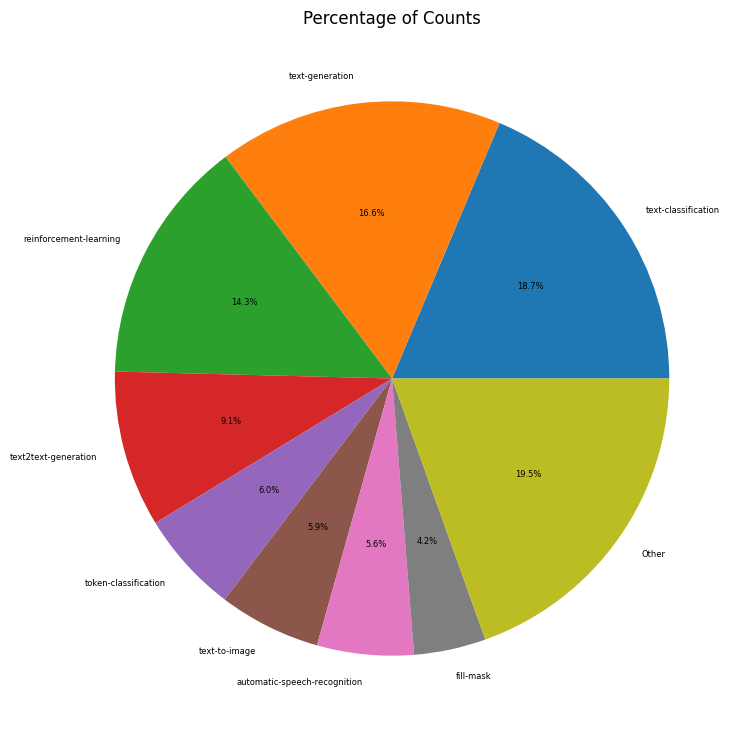

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the directory path
directory = './data'

# Initialize a dictionary to store the counts
counts = {}

# Initialize the global count variable
global_count = 0

# Iterate through the files in the directory
for filename in os.listdir(directory):
    # Exclude the "__bulk__.txt" file
    if filename != "__bulk__.txt":
        # Open the file and count the number of lines
        with open(os.path.join(directory, filename), 'r') as file:
            count = sum(1 for line in file)
        
        # Add the count to the dictionary
        counts[filename] = count
        
        # Update the global count
        global_count += count

# Sort the counts dictionary by value in descending order
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Calculate the threshold value
threshold = global_count * 0.8

print(f"Sorted counts: {sorted_counts}")

# Initialize lists to store the labels and values for the pie chart
labels = []
values = []

# Iterate through the sorted counts and add the labels and values to the lists
other_count = 0
for filename, count in sorted_counts.items():
    if other_count <= threshold:
        labels.append(filename.replace('.txt',''))
        values.append(count)
        other_count += count
    else:
        labels.append("Other")
        values.append(global_count - other_count)
        break

fig, ax = plt.subplots(figsize=(9, 9))

# Plot the pie chart
plt.pie(values, labels=labels, autopct='%.1f%%', textprops={'fontsize': 6})
plt.title('Percentage of Counts')
plt.show()


## Is there a varying pattern from one category to another which is followed ? 
The previous results show that,globally, there is no semantic version control. However given that 21% of the models contain a semantic version, which is an important number : 39k, we were enticed to dig deeper and see if its spread out accross different model categories or whether there are specific categories that follow semantic versionning. 
Our hunch was correct. As the dataset is made up of 42 categories, with some being more voluminous than the other, a couple heavy datasets stood out, while the rest was mostly at an adoption rate below 20%.
Indeed the "Reinforcement Learning" and "Automatic Speech Recognition" categories have an important adoption rate of semantic versionning. 
Could it be that this way of versionning models is not well suited for other categorise and a differnt semantic versionning model is adopted ? 

To check this hypothesis, we are going to manually dig out patterns (if present) from the models names in the biggest datasets which make up 80% of the total (parito law in place ;)), and then rely on our scripts to validate the adoption of the extracted patterns.

We will not take into consideration the models in "Reinforcement Learning" and "Automatic Speech Recognition", as these categories have a globally established semantic versionning pattern.

This leaves with this list of tasks categories : 
- text classifcation
- text generation
- text to text generation
- token classification
- text to image
- fill-mask

Important considerations : We don't take into consideration whether the position of the versionning token is consistent across all its occurences because with a simple human verification it doesn't seem to respect it.

Manually these patterns were found : 
- text classification : 
- text generation : \d[.-]?\d?bpw[.-]?[h|hB]?\d?[.-]?(exl)?\d?[.-]?\d?, GPTQ, AWQ, GGUF, GGUML, 3b, 7b, 13b, small, medium, large, base, finetuned



## Script to extract versionning patterns :

In this section, we present a script for analyzing the versionning patterns of the models by tasks categories. The script developed for this purpose reflects a series of deliberate methodological choices to reach our goal.

### Model Name Tokenization and Selection Criteria

Initially, the script addresses the complex nature of model names, which often comprise multiple tokens separated by hyphens or dots. We opted to consider only the first token of these names, postulating that the subsequent segments predominantly function as version indicators. This approach, while simplifying the model names, is justified by the observation that multi-token names are generally unique and infrequent. Thus, focusing on the first token is unlikely to introduce significant bias in detecting versioning patterns, ensuring that our analysis remains focused on the most representative elements of the dataset.

### Exclusion of Single-Entry Models

Another critical aspect of our methodology was the exclusion of models that appeared only once in the dataset. The underlying hypothesis here is that single-entry models are less likely to have undergone versioning, thereby offering limited insights into the evolution of models versions names. This decision effectively narrows the scope of our analysis to models with multiple versions, aligning more closely with the objectives of our study.

### Handling of Numerical Tokens

In the versioning analysis, the script specifically excludes numerical tokens. This decision is rooted in the recognition that numerical identifiers are standard in semantic versioning practices within software development. Since our interest lies in exploring less conventional and more nuanced versioning patterns, numerical tokens are considered less informative for this purpose. The exclusion of these tokens is thus a strategic decision to focus our analysis on uncovering more unique and insightful versioning schemes.

In [3]:
## target tasks categories 
files = ['text-classifcation.txt', 'text-generation.txt', 'text2text-generation.txt', 'token-classification.txt', 'text-to-image.txt', 'fill-mask.txt']

In [9]:
def extract_versionning_tokens(directory, files):
    # Initialize a dictionary to store the dictionary for each file
    global_dictionary = {}

    # Process each file
    for file_name in files:
        # Construct the file path
        file_path = os.path.join(directory, file_name)

        # Read the file and tokenize the model names
        with open(file_path, 'r') as file:
            models = [line.split('/')[1].strip() for line in file if '/' in line]

        # models with versions
        models = [model for model in models if '-' or '.' in model]

        # model names
        models_names = [model.split('-')[0].split('.')[0] for model in models]

        # models names with multiple versions
        multi_versions_models_names = [name_part for name_part, count in collections.Counter(models_names).items() if count > 1]

        # models with multiple versions
        multi_versions_models = [model for model in models if model.split('-')[0].split('.')[0] in multi_versions_models_names]

        multi_versions_models_dict = {}

        for model in multi_versions_models:
            model_name = model.split('-')[0].split('.')[0]
            version = "-".join(model.split('-')[1:]) if model.split('-')[0] in multi_versions_models_names else ".".join(model.split('.')[1:]) 
            version = re.sub(r'-?[vV]\d\.?\d?\.?\d?', '', version) 
            version = re.split(r'-', version) 
            version = [re.split(r'\.', version) if re.search(r'\d\.\d',version) is None else [version] for version in version]
            version = [[version for version in versions if version != ''] for versions in version]
            version = [token for version in version for token in version]
            version = [token for token in version if not token.isdigit()]
            version = [token for token in version if len(token) > 1]

            for token in version:
                if model_name in multi_versions_models_dict:
                    existing_tokens = multi_versions_models_dict[model_name]
                    if token.lower() not in existing_tokens:
                        multi_versions_models_dict[model_name].append(token.lower())
                else:
                    multi_versions_models_dict[model_name] = [token.lower()]

        # create the directory if it doesn't exist
        if not os.path.exists('./outputs/multi_versions_models_dict'):
            os.makedirs('./outputs/multi_versions_models_dict')

        # export the dictionary
        with open(f'./outputs/multi_versions_models_dict/{file_name.replace(".txt","")}.txt', 'w') as file:
            for model, versions in multi_versions_models_dict.items():
                file.write(model + ': ' + ', '.join(versions) + '\n')

        # update the global dictionary by adding this file's name as key and it's dictionary as value
        global_dictionary[file_name.replace('.txt','')] = multi_versions_models_dict

        tokens = [token for model, versions in multi_versions_models_dict.items() for token in versions]

        # Count the occurrence of individual tokens and combinations
        token_counts = collections.Counter(tokens)

        # Find the top tokens and combinations
        top_tokens = token_counts.most_common(100)

        # Print the top tokens and combinations
        print(top_tokens)

    return global_dictionary

# Define the directory path
directory = './data'

# Define the list of file names
files = ['text-classification.txt', 'text-generation.txt', 'text2text-generation.txt', 'token-classification.txt', 'text-to-image.txt', 'fill-mask.txt']

# Call the function
global_dictionary = extract_versionning_tokens(directory, files)


[('base', 314), ('bert', 228), ('finetuned', 223), ('classification', 172), ('model', 160), ('sentiment', 160), ('roberta', 159), ('large', 154), ('classifier', 116), ('distilbert', 112), ('uncased', 105), ('emotion', 68), ('detection', 68), ('mnli', 66), ('news', 66), ('cased', 58), ('small', 57), ('analysis', 57), ('sst2', 53), ('text', 50), ('test', 49), ('cola', 47), ('mrpc', 47), ('fine', 45), ('imdb', 41), ('tuned', 41), ('setfit', 40), ('twitter', 39), ('en', 38), ('detector', 38), ('multi', 35), ('tweet', 34), ('all', 34), ('rte', 31), ('hate', 31), ('nli', 31), ('intent', 31), ('english', 30), ('binary', 30), ('class', 30), ('deberta', 30), ('tweets', 29), ('multilingual', 29), ('onnx', 28), ('stsb', 28), ('data', 28), ('xlm', 28), ('qnli', 27), ('distilroberta', 27), ('reviews', 26), ('anomaly', 26), ('anomaly_baseline', 26), ('ft', 25), ('topic', 25), ('with', 25), ('distilled', 25), ('cls', 24), ('tiny', 24), ('review', 24), ('es', 23), ('finetune', 23), ('new', 23), ('samp

In [11]:
def generate_wordclouds(global_dictionary):
    # Calculate the number of keys in the global_dictionary
    num_keys = len(global_dictionary)

    # Calculate the number of rows and columns for the subplots
    num_rows = (num_keys + 2) // 3
    num_cols = min(num_keys, 3)

    # Set up the matplotlib figure
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))
    axs = axs.flatten()

    # Iterate through the global dictionary
    for i, (file_name, file_dict) in enumerate(global_dictionary.items()):
        # file top tokens
        tokens = [token for model, versions in file_dict.items() for token in versions]
        token_counts = collections.Counter(tokens)
        top_tokens = token_counts.most_common(100)

        # Extract the strings and occurrences from the file's dictionary
        strings = [token[0] for token in top_tokens]
        occurrences = [token[1] for token in top_tokens]

        # Create a dictionary of word frequencies
        word_frequencies = dict(zip(strings, occurrences))

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_frequencies)

        # Display the word cloud in the corresponding subplot
        axs[i].imshow(wordcloud, interpolation='bilinear')
        axs[i].set_title(file_name)
        axs[i].axis('off')

        # Save the chart to a file
        image_path = os.path.join('./images', f'{file_name}_wordcloud.png')
        wordcloud.to_file(image_path)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

# Call the function with the global_dictionary as the argument
generate_wordclouds(global_dictionary)


In [42]:
def find_common_token_groups_combinations(global_dictionary, output_directory):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Initialize the dictionary to store the results
    common_groups_dict = {}

    # Iterate over the entries in the global_dictionary
    for key, model_tokens in global_dictionary.items():
        # Create a new dictionary to store the tokens for the current key
        model_tokens_new = {}

        # Populate the new dictionary with the tokens
        for model, tokens in model_tokens.items():
            model_tokens_new[model.strip()] = set(tokens)

        # Find common groups of tokens
        common_groups_count_new = defaultdict(int)
        for (model1, tokens1), (model2, tokens2) in itertools.combinations(model_tokens_new.items(), 2):
            common_tokens = frozenset(tokens1.intersection(tokens2))
            if common_tokens:
                common_groups_count_new[common_tokens] += 1

        # Filter groups to include only those with 2 or more elements
        filtered_common_groups_2_or_more = {group: count for group, count in common_groups_count_new.items() if len(group) >= 2}

        # Sort the filtered dictionary by count
        sorted_filtered_common_groups_2_or_more = sorted(filtered_common_groups_2_or_more.items(), key=lambda x: x[1], reverse=True)

        # Store the results in the dictionary
        common_groups_dict[key] = sorted_filtered_common_groups_2_or_more

        # Create the file path for the current key
        file_path = os.path.join(output_directory, f'{key}.txt')

        # Write the results to the file
        with open(file_path, 'w') as file:
            for group, count in sorted_filtered_common_groups_2_or_more:
                file.write(f"Tokens: {group} - Occurred in {count} combinations\n")

    return common_groups_dict

# Define the output directory
output_directory = './outputs/versioning_tokens_groups_combinations'

# Call the function
common_groups_dict = find_common_token_groups_combinations(global_dictionary, output_directory)


In [16]:
def find_common_token_groups_in_models(global_dictionary):
    # Define a dictionary to store the results for each key
    results_dict = {}

    # Iterate over the keys in the global_dictionary
    for key, model_tokens in global_dictionary.items():
        # Extract the model tokens from the global_dictionary
        model_tokens = {model: set(tokens) for model, tokens in model_tokens.items()}

        # Find common groups of tokens
        common_groups_count_new = defaultdict(int)
        for (model1, tokens1), (model2, tokens2) in itertools.combinations(model_tokens.items(), 2):
            common_tokens = frozenset(tokens1.intersection(tokens2))
            if common_tokens:
                common_groups_count_new[common_tokens] += 1

        # Filter groups to include only those with 2 or more elements
        filtered_common_groups_2_or_more = {group: count for group, count in common_groups_count_new.items() if len(group) >= 2}

        # Sort the filtered dictionary by count
        sorted_filtered_common_groups_2_or_more = sorted(filtered_common_groups_2_or_more.items(), key=lambda x: x[1], reverse=True)

        # Store the results in the results_dict using the current key
        results_dict[key] = sorted_filtered_common_groups_2_or_more

        # Iterate over top_20_common_groups_3_or_more_new
        top_20_common_groups_3_or_more_new_two = []
        for group, count in results_dict[key]:
            # Find models that share the interested group of tokens
            models_with_interesting_tokens = set()
            for model, tokens in model_tokens.items():
                if tokens >= group:  # Checks if tokens include all the interested tokens in the group
                    models_with_interesting_tokens.add(model)

            top_20_common_groups_3_or_more_new_two.append((group, len(models_with_interesting_tokens)))

        top_20_common_groups_3_or_more_new_two = sorted(top_20_common_groups_3_or_more_new_two, key=lambda x: x[1], reverse=True)

        # Store the results in the results_dict for the current key
        results_dict[key] = top_20_common_groups_3_or_more_new_two

    return results_dict

# Call the function with the global_dictionary as the argument
results_dict = find_common_token_groups_in_models(global_dictionary)

{'text-classification': [(frozenset({'bert', 'base'}), 101), (frozenset({'finetuned', 'base'}), 98), (frozenset({'large', 'base'}), 97), (frozenset({'roberta', 'base'}), 90), (frozenset({'base', 'uncased'}), 88), (frozenset({'base', 'classification'}), 82), (frozenset({'sentiment', 'base'}), 78), (frozenset({'roberta', 'bert'}), 77), (frozenset({'sentiment', 'finetuned'}), 67), (frozenset({'finetuned', 'classification'}), 64), (frozenset({'sentiment', 'classification'}), 60), (frozenset({'base', 'distilbert'}), 59), (frozenset({'bert', 'classification'}), 58), (frozenset({'bert', 'model'}), 55), (frozenset({'bert', 'distilbert'}), 55), (frozenset({'sentiment', 'bert'}), 54), (frozenset({'bert', 'uncased'}), 54), (frozenset({'classification', 'model'}), 53), (frozenset({'base', 'classifier'}), 53), (frozenset({'roberta', 'large'}), 52), (frozenset({'roberta', 'bert', 'base'}), 52), (frozenset({'base', 'cased'}), 51), (frozenset({'sentiment', 'analysis'}), 51), (frozenset({'base', 'model

/tmp/ipykernel_12865/3051209719.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_bars)


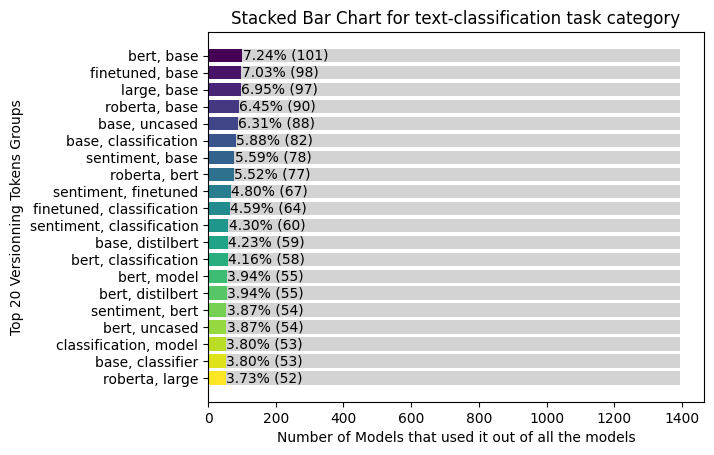

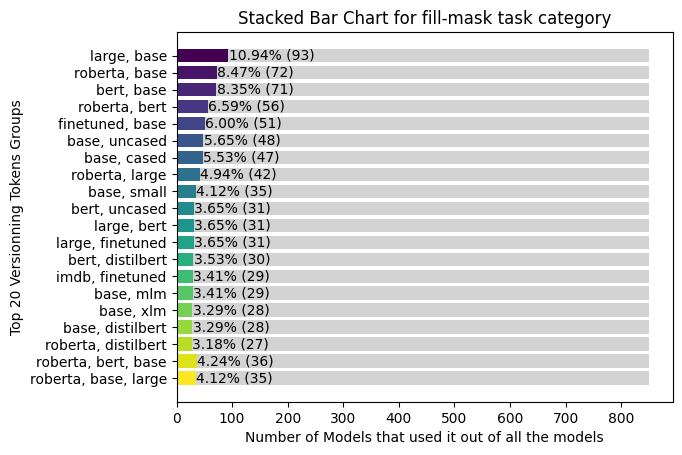

<Figure size 640x480 with 0 Axes>

In [59]:
import os
def plot_stacked_barcharts(results_dict, output_directory):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Iterate over the entries in the results_dict
    for key, results in results_dict.items():
        # Extract the groups and counts from the results
        groups = [', '.join(group) for group, count in results[:20]]
        counts = [count for group, count in results[:20]]

        # Order the groups by the number of subgroups
        groups_counts = sorted(zip(groups, counts), key=lambda x: len(x[0].split(', ')))
        groups, counts = zip(*groups_counts)

        # Calculate the total count
        total_count = sum(counts)

        # Calculate the percentages
        percentages = [count / total_count * 100 for count in counts]

        # Calculate the number of bars
        num_bars = len(groups)

        # Generate a colormap with a gradual scaling
        colors = cm.get_cmap('viridis', num_bars)
        colors = [colors(i) for i in range(num_bars)]

        # Calculate the remaining counts
        remaining_counts = [total_count - count for count in counts]

        # Create a horizontal stacked bar chart
        plt.barh(groups, counts, color=colors, label='Current Count')
        plt.barh(groups, remaining_counts, left=counts, color='lightgray', label='Remaining Count')

        # Set the labels and title
        plt.xlabel('Number of Models that used it out of all the models')
        plt.ylabel('Top 20 Versionning Tokens Groups')
        plt.title(f'Stacked Bar Chart for {key} task category')

        # Invert the chart from top to bottom
        plt.gca().invert_yaxis()

        # Add annotations
        offset = max(counts) * 0.01  # 1% of the maximum count for a slight offset
        for group, count, percentage, y in zip(groups, counts, percentages, range(len(groups))):
            plt.annotate(f'{percentage:.2f}% ({count})', xy=(count + offset, y), ha='left', va='center')

        # Save the chart to a file with high resolution and quality
        image_path = os.path.join(output_directory, f'{key}_stacked_barchart.png')
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.show()
        # Clear the plot
        plt.clf()

# Define the output directory
output_directory = './images/stacked_barcharts'

# Call the function with the results_dict and output_directory as the arguments
plot_stacked_barcharts(results_dict, output_directory)


- Groups of one are not interesting since we seek cross-models versionning patterns
- Groups of two indicate two types of token groups : Conceptual Categories, Numerical Sequences. They are also combined at times. The presence of both types within these groups suggests that versioning could be occurring across multiple dimensions or aspects. The conceptual categories might represent different types of changes or updates, while numerical sequences could represent more quantifiable changes like version numbers or incremental updates to the size of input, or weights or other technical components...
- Groups of three and more further emphasize the previous observation : there are different semantical progressions in the versionning tokens, which are combined too. This could imply a more complex versioning system where multiple aspects or dimensions are being updated simultaneously.

Number of groups for text-classification: 300


<Figure size 640x480 with 0 Axes>

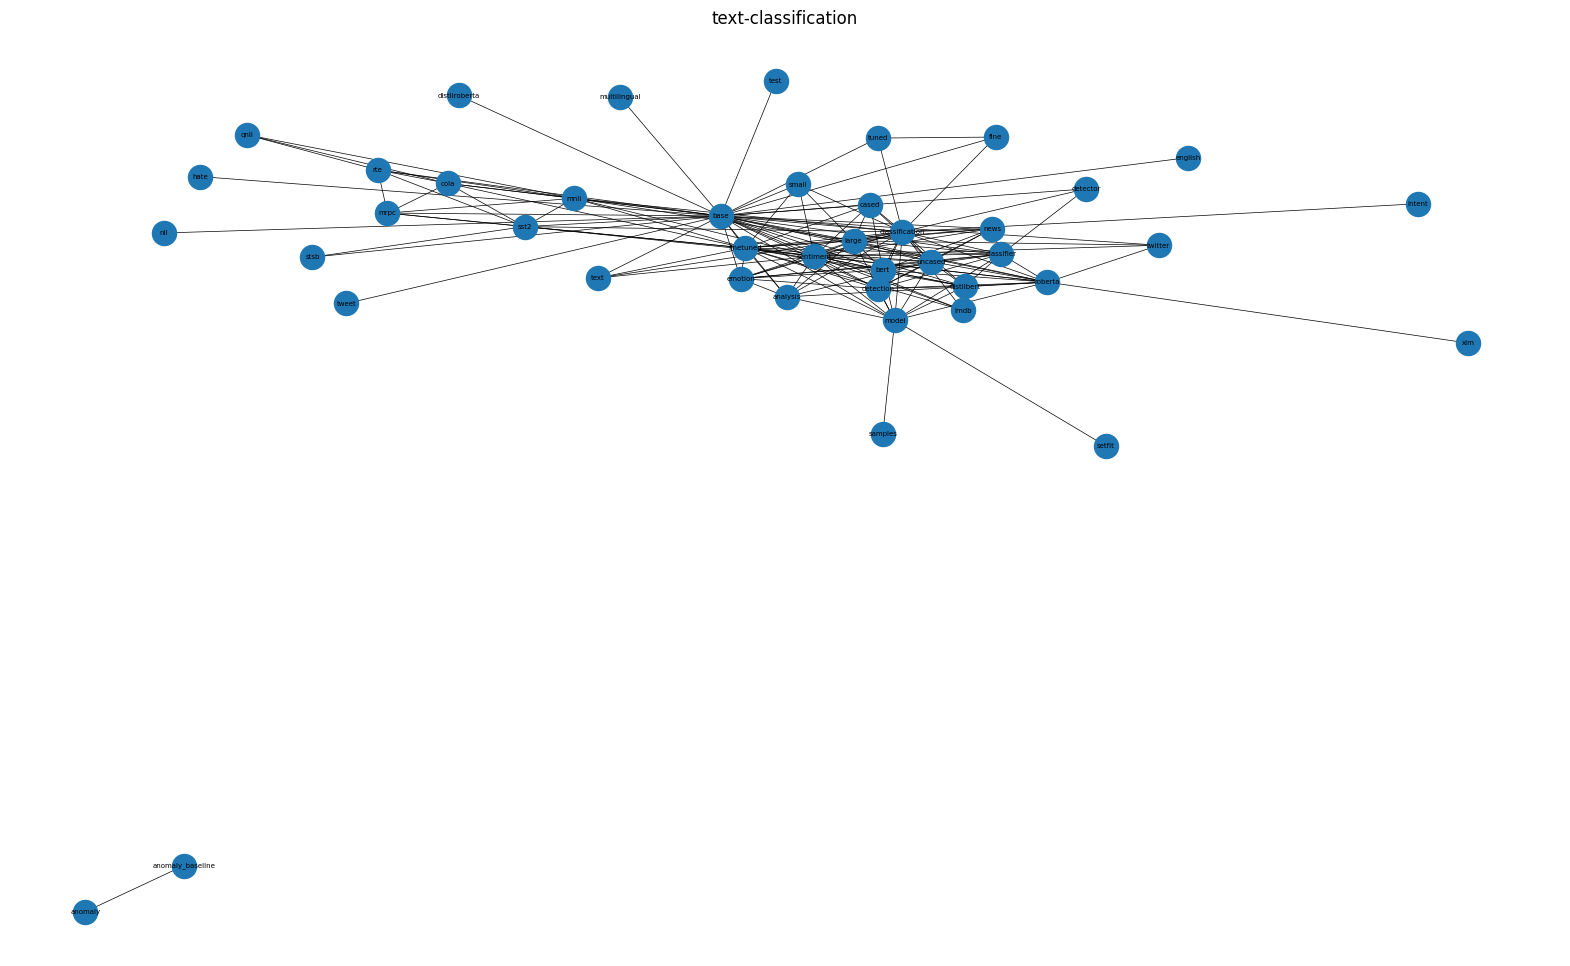

Number of groups for text-generation: 300


<Figure size 640x480 with 0 Axes>

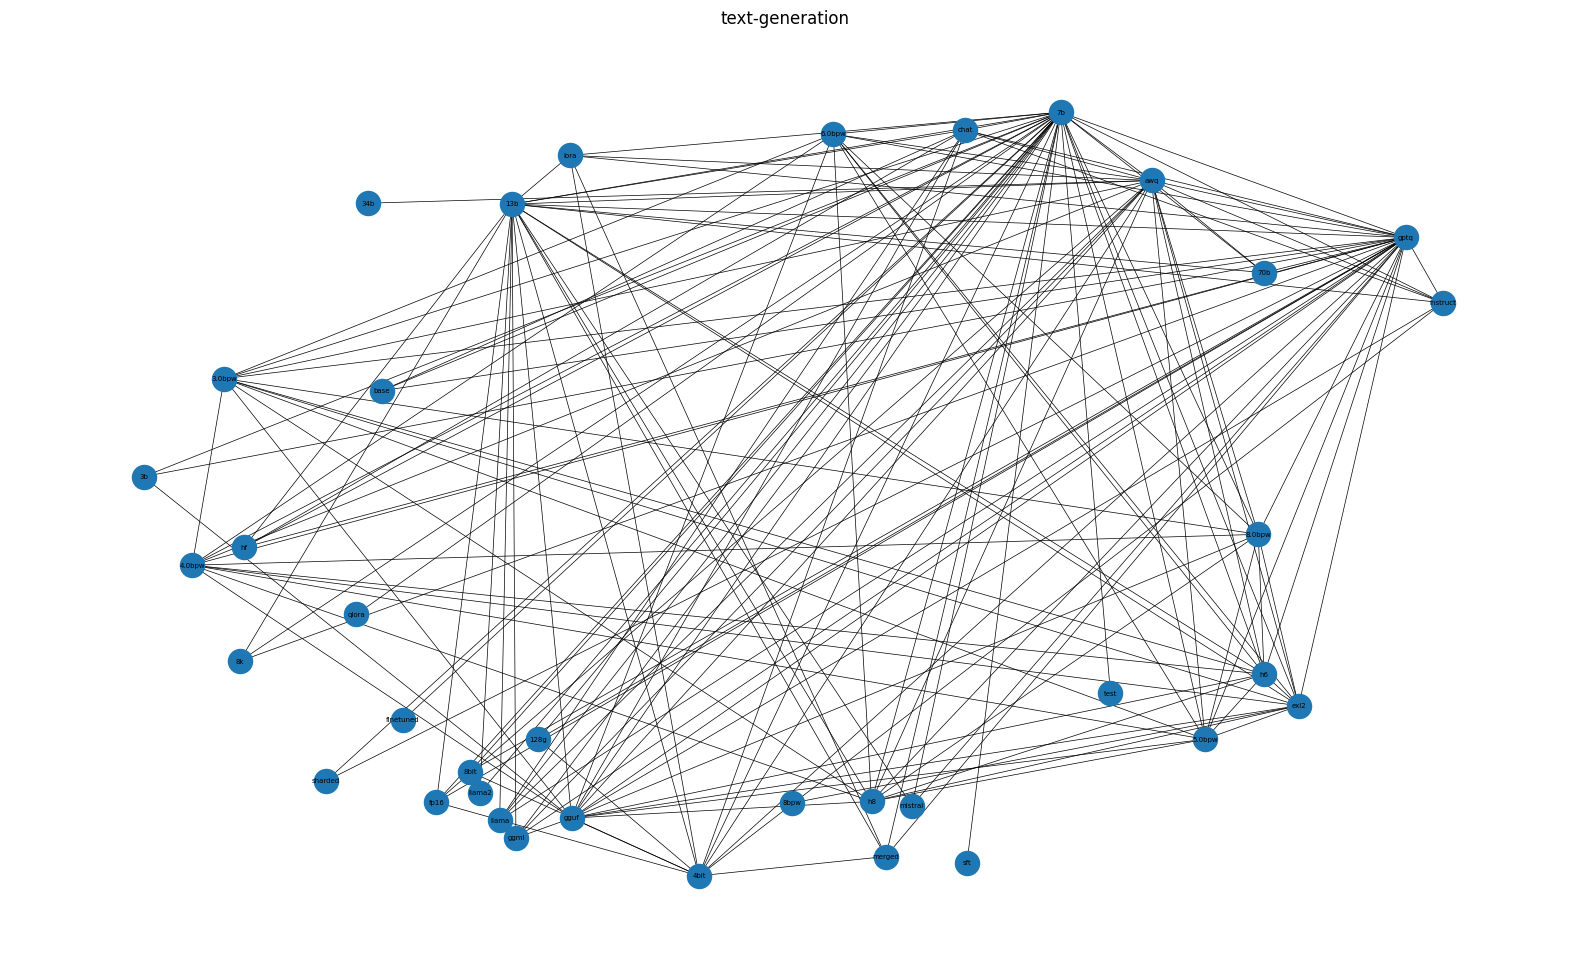

Number of groups for text2text-generation: 300


<Figure size 640x480 with 0 Axes>

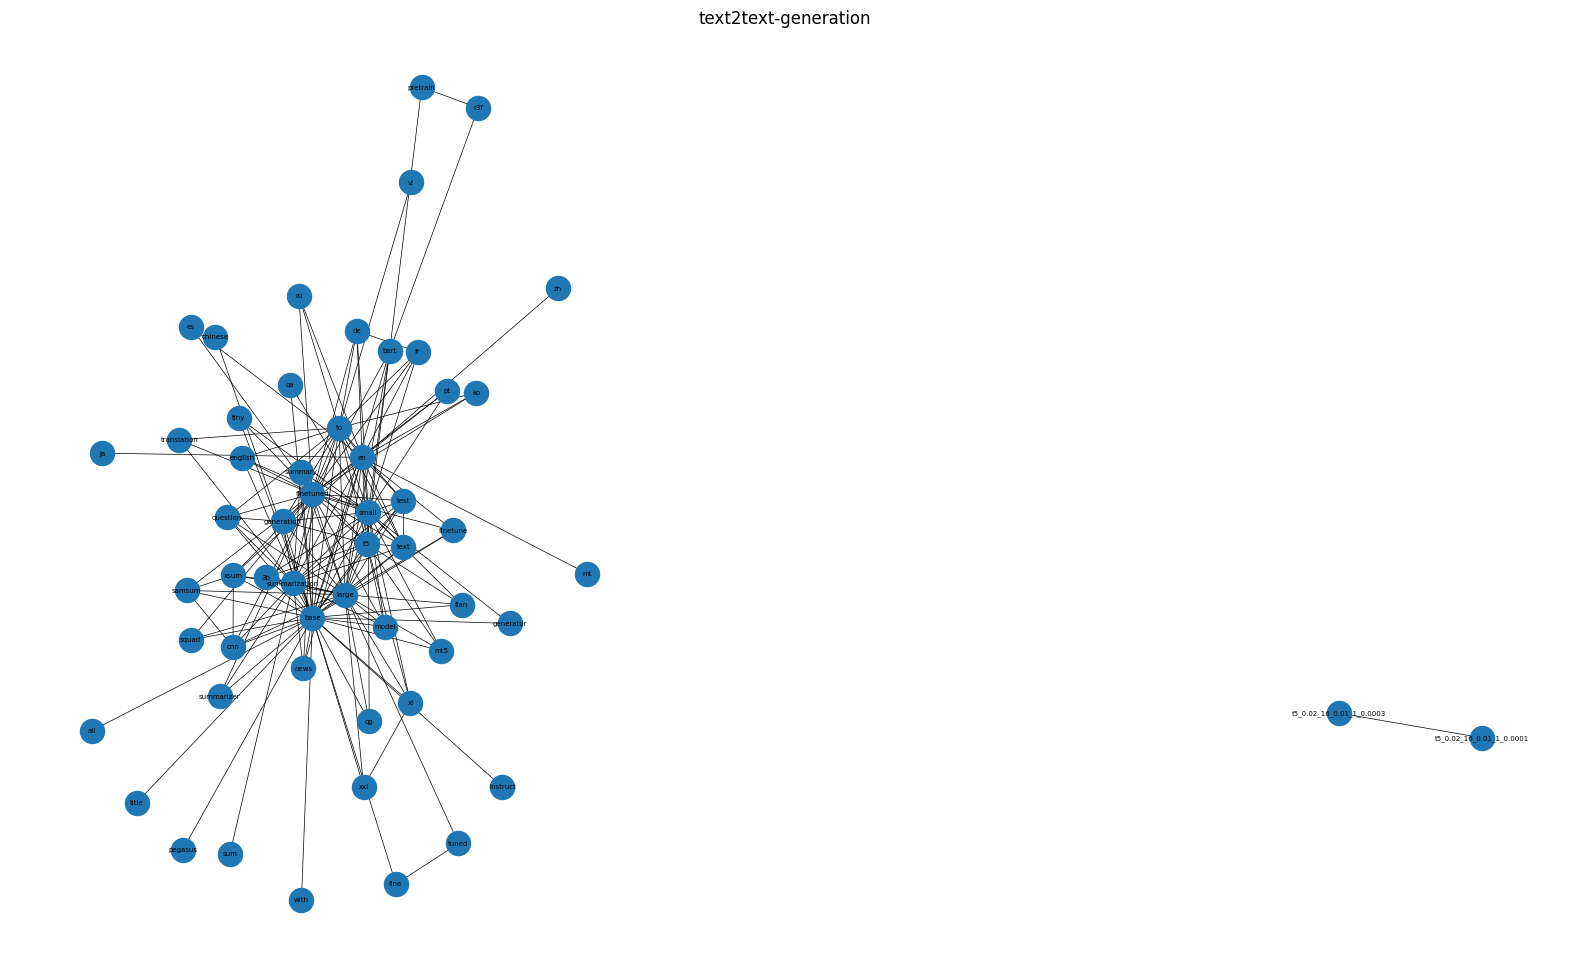

Number of groups for token-classification: 300


<Figure size 640x480 with 0 Axes>

Number of groups for text-to-image: 300


<Figure size 640x480 with 0 Axes>

Number of groups for fill-mask: 300


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_network_graph(results_dict, output_directory):
    # Normalize function
    def normalize(values):
        min_val = min(values)
        max_val = max(values)
        if min_val == max_val:
            return [0.5] * len(values)
        return [(val - min_val) / (max_val - min_val) for val in values]

    # Clear any existing plots
    plt.cla()
    plt.close()
    plt.clf()

    # Iterate over the keys and values in results_dict
    for key, results in results_dict.items():
        # skip unploatable keys
        if len(results) < 2:
            continue

        top_groups_updated = []

        # Filtering the common groups to keep only those whose count is not too far from the top count using quantiles
        for group, count in results:
            if count >= 0.05 * results[0][1] and len(top_groups_updated) < 300:
                top_groups_updated.append((group, count))

        print(f"Number of groups for {key}: {len(top_groups_updated)}")

        # Extracting counts for normalization
        counts = [count for _, count in top_groups_updated]
        normalized_counts = counts

        # Scale down the counts
        normalized_counts = [count/40 for count in normalized_counts]

        # Create a network graph
        G = nx.Graph()

        # Add nodes and edges with normalized weights
        for (tokens, _), norm_count in zip(top_groups_updated, normalized_counts):
            tokens = list(tokens)
            inverse_weight = 1 - norm_count  # Inverse normalized weight
            for i in range(len(tokens)):
                for j in range(i + 1, len(tokens)):
                    G.add_edge(tokens[i], tokens[j], weight=inverse_weight)

        # Define the layout
        pos = nx.spring_layout(G, weight='weight')  # Use the weight for layout

        # Set up the figure
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.set_title(key)
        ax.axis('off')

        # Nodes
        nx.draw_networkx_nodes(G, pos, node_size=300, ax=ax)

        # Edges
        for (u, v, d) in G.edges(data=True):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=0.5, ax=ax)

        # Labels
        nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif', ax=ax)

        # Save the chart to a file with high resolution and quality
        image_path = os.path.join(output_directory, f'{key}_network_graph.png')
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
        
        # Show the plot
        plt.show()

        # Clear the plot
        plt.cla()
        plt.close()
        plt.clf()

# output directory
output_directory = './images/network_graphs'

# Call the function with the results_dict as the argument
plot_network_graph(results_dict, output_directory)


## Conclusion 

No versionning pattern is adopted and agreed upon in any category. Many versionning patterns are detected, but they are very infinitizimal to be considered a norm. 

## Do big companies adopt any consistent form of semantic versionning for their models ? 

For this purpose we will continue our study with only models artifacts pushed by by google, facebook/meta and openai.

With google having push 617 artifacts, facebook/meta 1879 artifacts and openai 32 artifacts.



In [ ]:
owners = ["google","facebook","openai"]

In [36]:
model_ids = {}

for owner in owners:
    url = f"https://huggingface.co/api/models/?author={owner}"
    response = requests.get(url)
    json_data = response.json()
    model_ids[owner] = [data["modelId"] for data in json_data]

# Create the directory if it doesn't exist
directory = './data'
if not os.path.exists(directory):
    os.makedirs(directory)

# Write the result to separate files
for owner, ids in model_ids.items():
    file_path = os.path.join(directory, f'{owner}.txt')
    with open(file_path, 'w') as file:
        for model_id in ids:
            file.write(f'{model_id}\n')

[('base', 18), ('large', 17), ('small', 7), ('xxl', 7), ('xl', 6), ('patch16', 3), ('patch14', 3), ('arxiv', 2), ('pubmed', 2), ('nq', 2), ('wq', 2), ('3b', 2), ('lm', 2), ('mini', 2), ('tiny', 2), ('finetuned', 2), ('patch32', 2), ('t5', 2), ('bedroom', 2), ('celebahq', 2), ('church', 2), ('chartqa', 2), ('24_wmt_de_en', 1), ('24_wmt_en_de', 1), ('10_h', 1), ('128_a', 1), ('256_a', 1), ('512_a', 1), ('768_a', 1), ('12_h', 1), ('2_h', 1), ('4_h', 1), ('6_h', 1), ('8_h', 1), ('trivia', 1), ('itc', 1), ('pegasus', 1), ('bigpatent', 1), ('roberta', 1), ('discriminator', 1), ('generator', 1), ('seed_0', 1), ('step_0k', 1), ('step_1000k', 1), ('step_100k', 1), ('step_1100k', 1), ('step_1200k', 1), ('step_120k', 1), ('step_1300k', 1), ('step_1400k', 1), ('step_140k', 1), ('step_1500k', 1), ('step_1600k', 1), ('step_160k', 1), ('step_1700k', 1), ('step_1800k', 1), ('step_180k', 1), ('step_1900k', 1), ('step_2000k', 1), ('step_200k', 1), ('step_20k', 1), ('step_300k', 1), ('step_400k', 1), ('s

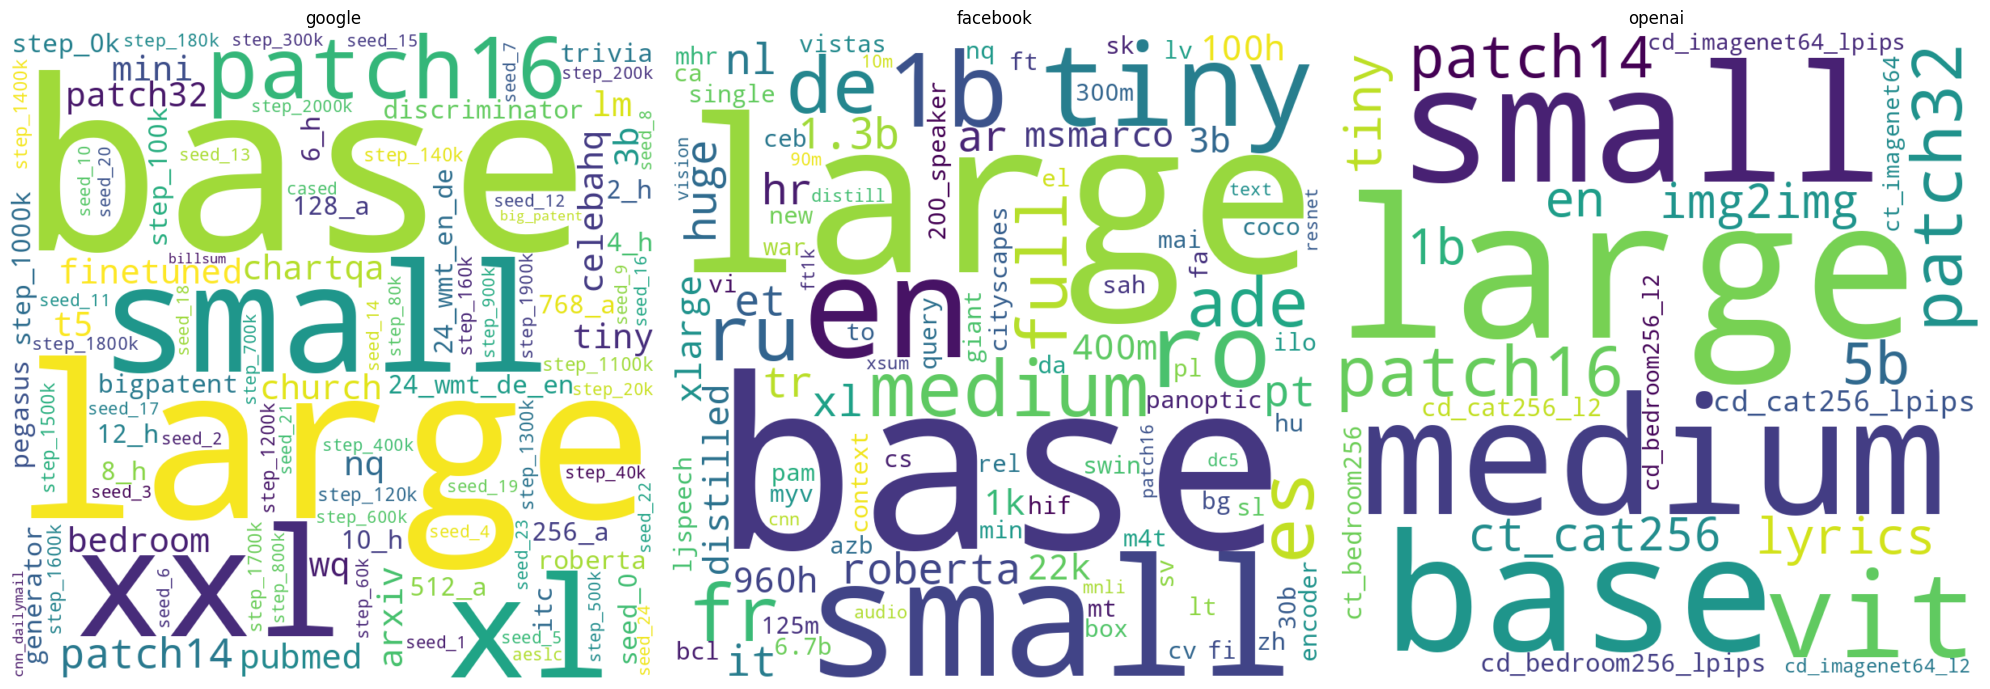

/tmp/ipykernel_12865/3423521306.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_bars)


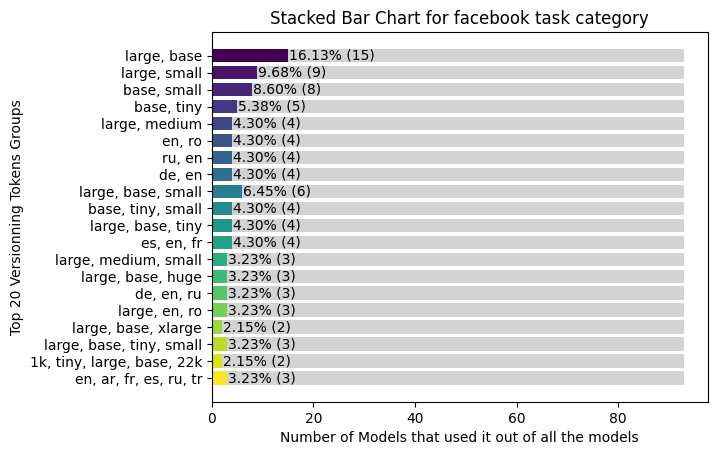

Number of groups for google: 20


<Figure size 640x480 with 0 Axes>

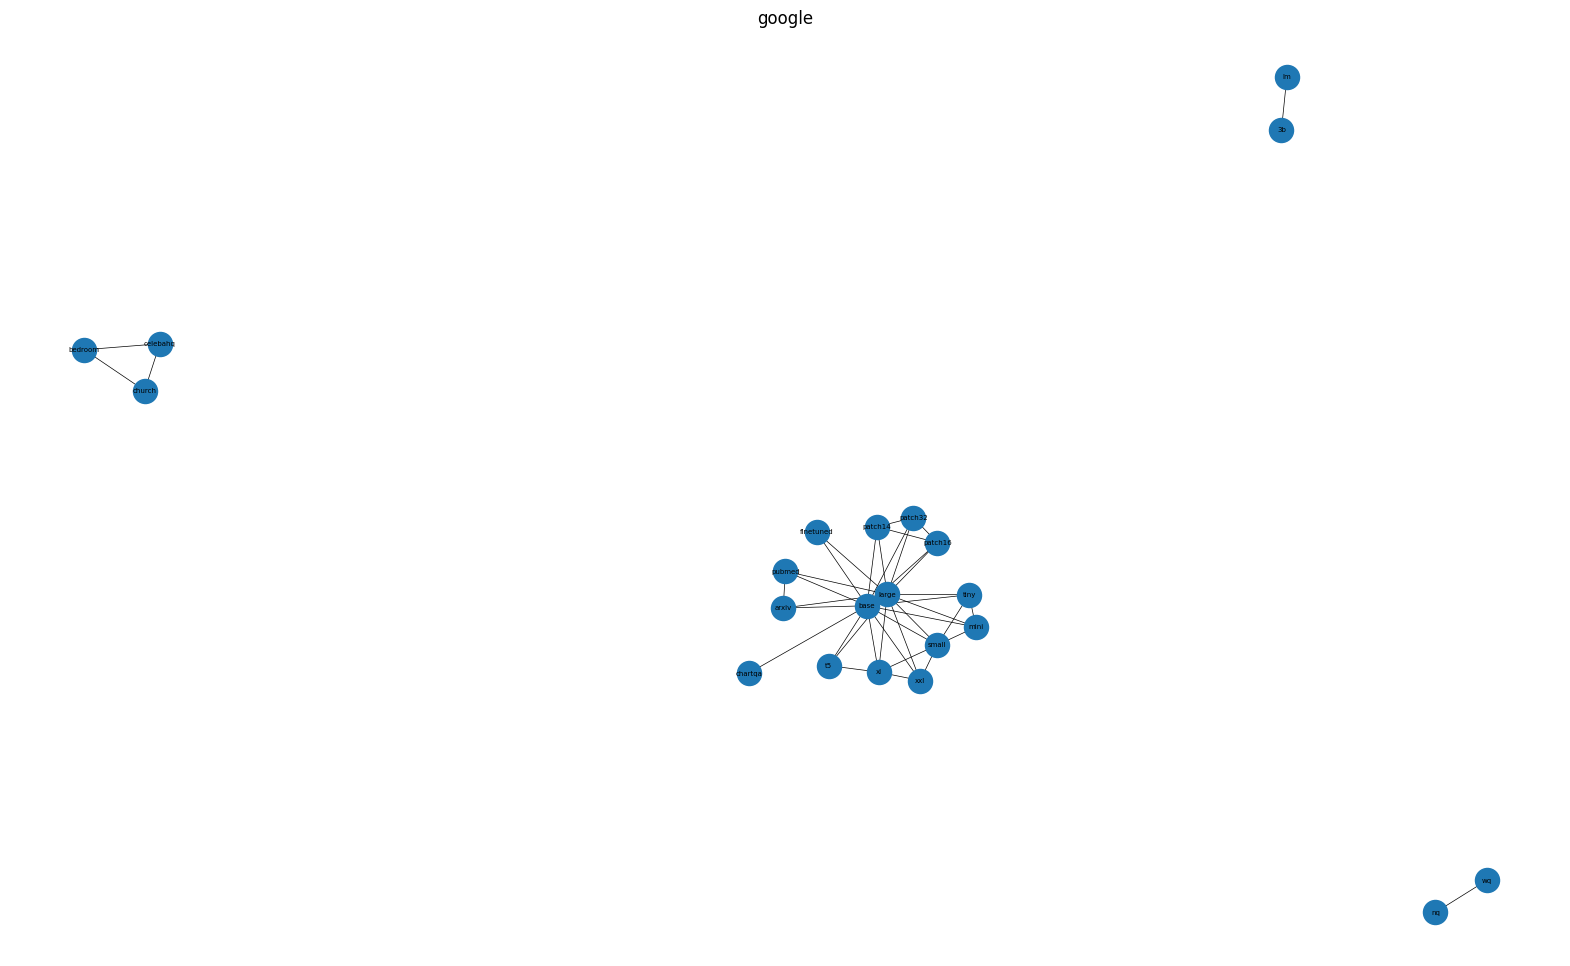

Number of groups for facebook: 38


<Figure size 640x480 with 0 Axes>

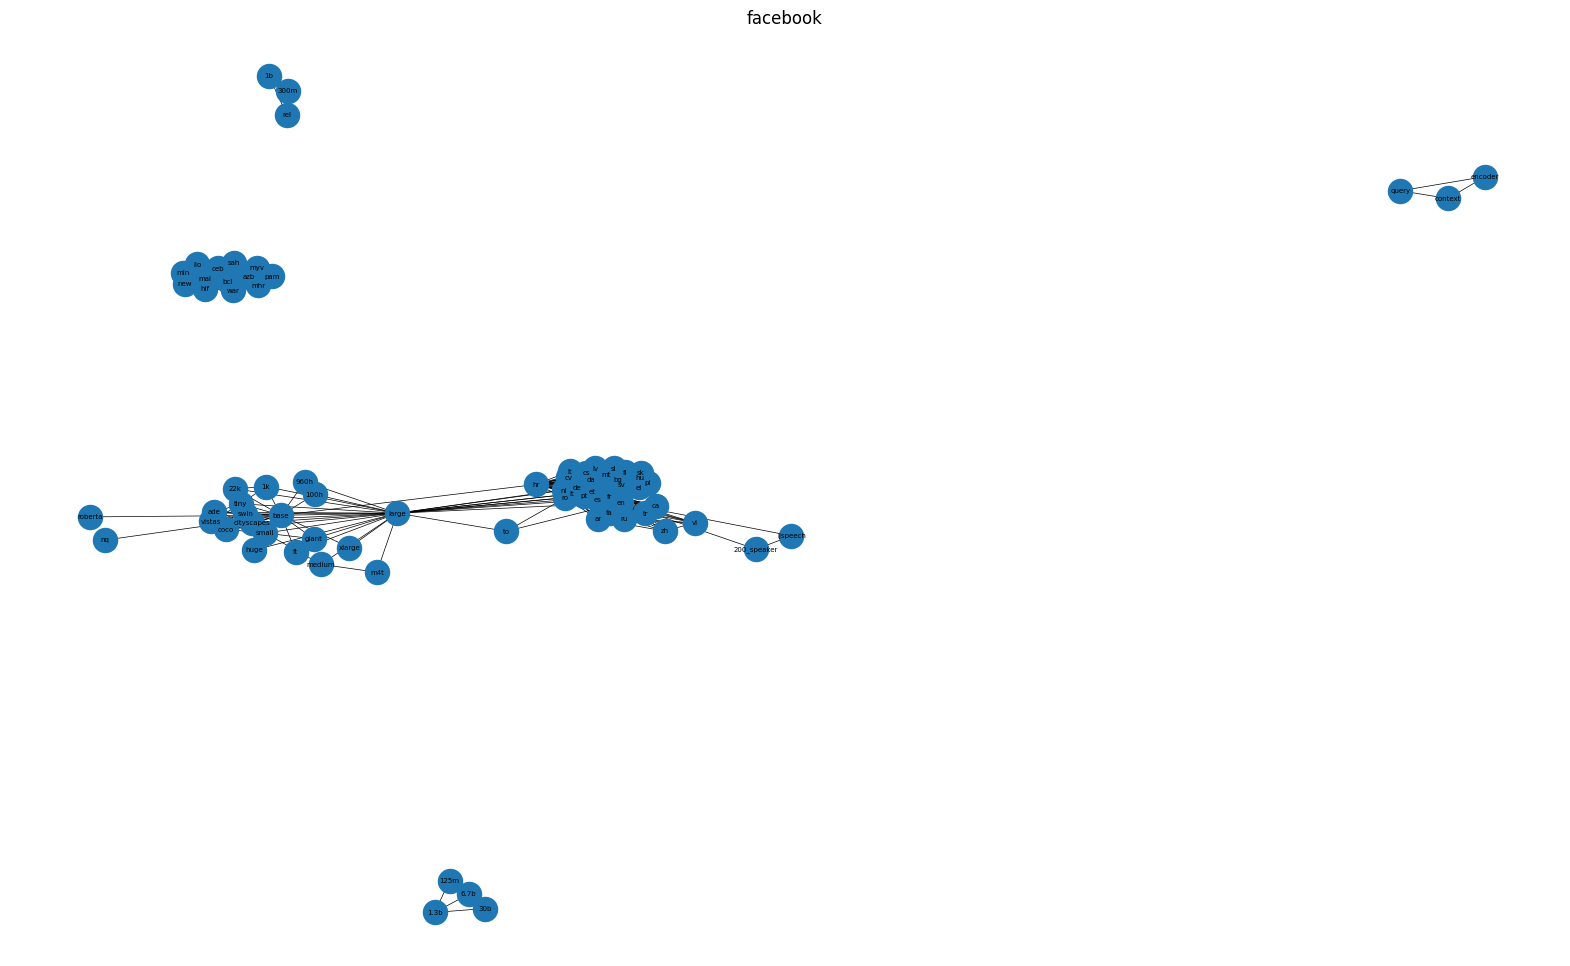

Number of groups for openai: 2


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [57]:
# Define the directory where the model IDs are stored
directory = './data'

# Define the list of files
files = [owner + '.txt' for owner in owners]

# extract versionning tokens for each owner
big_companies_dictionary = extract_versionning_tokens(directory, files)

print(f"Big Companies Dictionary: {big_companies_dictionary}")

# generate wordclouds for each owner
generate_wordclouds(big_companies_dictionary)

# find common token groups combinations for each owner
big_companies_common_groups_dict = find_common_token_groups_combinations(big_companies_dictionary, './outputs/big_companies_versioning_tokens_groups_combinations')

# find common token groups in models for each owner
big_companies_results_dict = find_common_token_groups_in_models(big_companies_dictionary)

# output directory for stacked barcharts
output_directory_stacked_barcharts = './images/big_companies_stacked_barcharts'

# plot stacked barcharts for each owner
plot_stacked_barcharts(big_companies_results_dict, output_directory_stacked_barcharts)

# output directory for network graph
output_directory_network_graph = './images/big_companies_network_graph'

# plot network graph for each owner
plot_network_graph(big_companies_results_dict, output_directory_network_graph)

